# IPCC AR6 Interactive Atlas Datalab

***

> This notebook is a reproducibility example of the IPCC-WGI AR6 Interactive Atlas products. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Regional averaging of climate information

**E. Cimadevilla** and **M. Iturbide** (Santander Meteorology Group. Instituto de Física de Cantabria, CSIC-UC, Santander, Spain).

This notebook is a reproducibility example for the [**IPCC-WGI AR6 Interactive Atlas**](https://interactive-atlas.ipcc.ch/) products. 

This notebook works with the data available in the [IPCC-Atlas-Datalab](https://github.com/SantanderMetGroup/IPCC-Atlas-Datalab). In particular, the **IPCC-WGI AR6 Interactive Atlas Dataset**, originally published at [**DIGITAL.CSIC**](https://digital.csic.es/handle/10261/280324) for the long-term archival, and also available through the **[Copernicus Data Store (CDS)](https://cds.climate.copernicus.eu/datasets/projections-climate-atlas?tab=overview)**.

Open the **`Getting_started.ipynb`** for a **description of the available data**.

### Contents in this notebook
1) Libraries
2) Data preparation
3) Application of a land-sea mask
4) Generate regionalized information
***

### 1. Libraries


In [1]:
import re
import math
import json
import requests

import xarray
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### 2. Data Preparation

The aim of this notebook is to illustrate the operations that can be carried out in *xarray* to synthesize climate information through regionalized statistics. For more detailed explanations on data loading, please refer to other notebooks (e.g., `getting started`).

In [2]:
df = pd.read_csv("../../data_inventory.csv")
df.head()

,location,type,variable,project,experiment,frequency
0,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,pr,CORDEX-ANT,historical,mon
1,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,tn,CORDEX-ANT,historical,mon
2,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,rx1day,CORDEX-ANT,historical,mon
3,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,tx,CORDEX-ANT,historical,mon
4,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,txx,CORDEX-ANT,historical,mon


* `location` refers to the path 
* `type` refers to the access mode, local (netcdf) or remote (opendap). 
* `variable` referst to the climatic variable or index (i.e. tas, pr, tn, rx1day, etc.)
* `project` refers to the project coordinating the datasets (i.e. CORDEX-EUR, CMIP5, CMIP6, etc.)
* `experiment` referst to the scenario (i.e. historical, rcp26, ssp126, rcp85, etc.)

We can easily apply filters to narrow down to the desired file. In this example the TXx index (maximum of maximum temperatures) from CMIP6,  for the historical and ssp370 experiments. The information piece we need is the `location`.

In [3]:
hist_url = df.query('type == "opendap" & variable == "txx" & project == "CMIP6" & experiment == "historical"')["location"].iloc[0]
ssp370_url = df.query('type == "opendap" & variable == "txx" & project == "CMIP6" & experiment == "ssp370"')["location"].iloc[0]

hist_url, ssp370_url

('https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/historical/txx_CMIP6_historical_mon_185001-201412.nc',
 'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp370/txx_CMIP6_ssp370_mon_201501-210012.nc')

Before loading the data, we can set common parameters such as the geographical domain, the target season (boreal summer in this example), the reference period for the historical baseline (in this case, the pre-industrial period) and the future period (in this case, the medioum term).

In [4]:
lats, lons = slice(25, 50), slice(-11, 40)

cmip6_hist = xarray.open_dataset(hist_url).sel(
    time=slice("18500101", "19001231"),
    lat=lats,
    lon=lons)
cmip6_hist = cmip6_hist.sel(time=(cmip6_hist.time.dt.month.isin([6,7,8])))

cmip6_ssp370 = xarray.open_dataset(ssp370_url).sel(
    time=slice("20410101", "20601231"),
    lat=lats,
    lon=lons)
cmip6_ssp370 = cmip6_ssp370.sel(time=(cmip6_ssp370.time.dt.month.isin([6,7,8])))

Before continuing, we must retain the same models (in the same order) in both the future and historical grids.

In [5]:
members = [x for x in cmip6_ssp370["member"].values if x in cmip6_hist["member"].values]

cmip6_hist = cmip6_hist.sel(member=members)
cmip6_ssp370 = cmip6_ssp370.sel(member=members)

It is always a good practice to make sure that the members in both grids are identical.

In [6]:
(cmip6_hist["member"] == cmip6_ssp370["member"]).all().item()

True

Calculate the climate change signal.

In [7]:
delta = cmip6_ssp370["txx"].mean("time") - cmip6_hist["txx"].mean("time")

Plot the map.

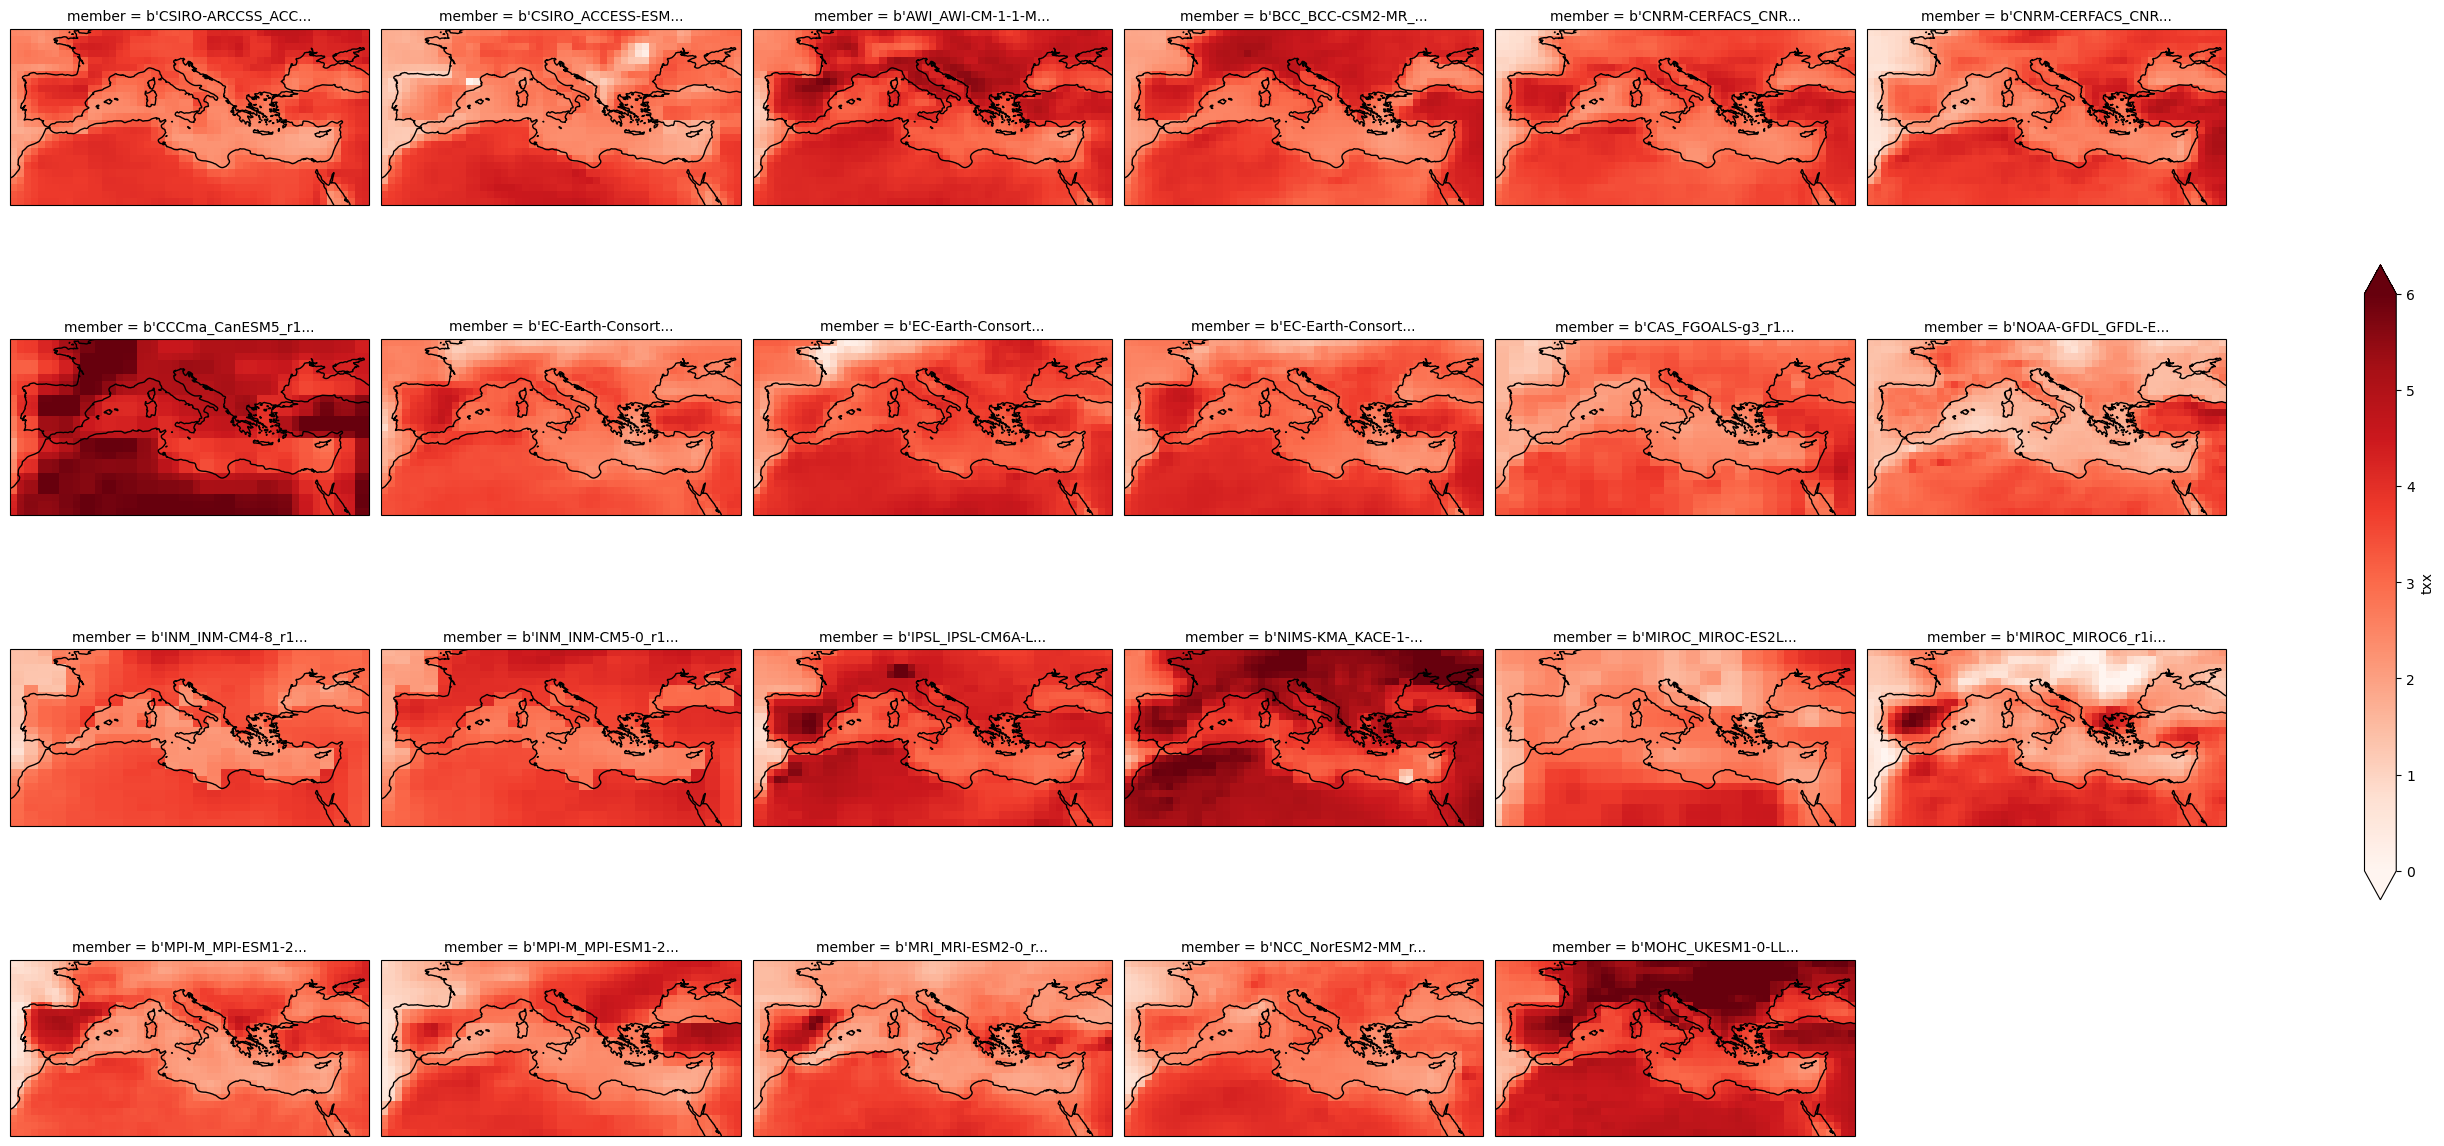

In [8]:
plot = delta.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    vmin=0, vmax=6,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-11,40,25,50), ccrs.PlateCarree())

plot.fig.savefig("txx-delta.svg")

Calculate and plot the map of the ensemble mean.

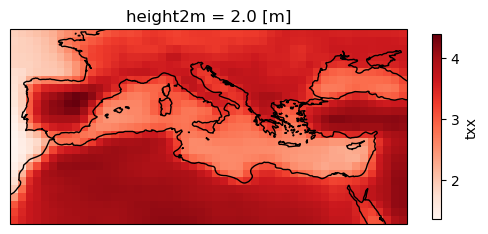

In [9]:
ens_mean = delta.mean("member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

plot.axes.coastlines()

### 3. Application of a land-sea mask

The land-sea masks necessary for this dataset are accessible in the IPCC-WGI/Atlas GitHub repository, which is mirrored here. Given that the CMIP6 data within the IPCC-WGI AR6 Interactive Atlas dataset adopts a consistent 1-degree grid, it is essential to reference the 1-degree mask (`land_sea_mask_1degree.nc4`) located in the same GitHub repository where the warming level information is available, this is the  [**IPCC-WGI/Atlas GitHub repository**](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels). Therefore we can load this mask also remotely and using the `lonLim` and `latLim` parameters defined previously.
The variable name is `sftlf` in this case. 

In [10]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/reference-grids/land_sea_mask_1degree.nc4"
mask_file = url.split("/")[-1]
with open(mask_file, "wb") as f:
    r = requests.get(url)
    r.raise_for_status()
    f.write(r.content)

In [11]:
mask = xarray.open_dataset(mask_file).sel(lon=lons, lat=lats)
sftlf = (mask["sftlf"] > 0.5).astype(int)

After loading the mask, we need to apply a threshold to the resulting grid to make it binary. In this example, we want to retain the data over the land areas.

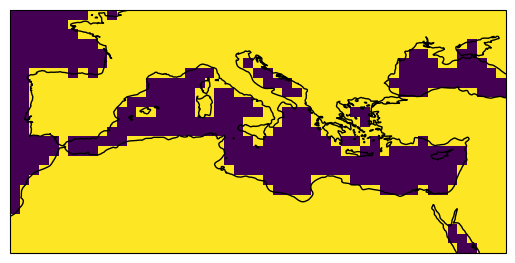

In [12]:
plot = sftlf.plot(
    add_colorbar=False,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())
plot.axes.coastlines()

Apply the mask to the ensemble mean.

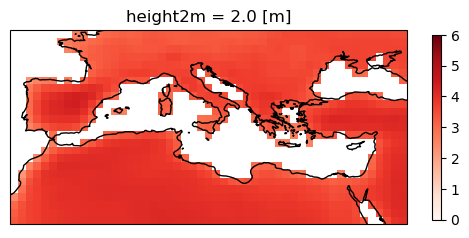

In [13]:
ens_mean_land = ens_mean * sftlf.where(sftlf==1)

plot = ens_mean_land.plot(
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    vmin=0, vmax=6,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())
plot.axes.coastlines()

Apply the same mask to the multi-model grid.

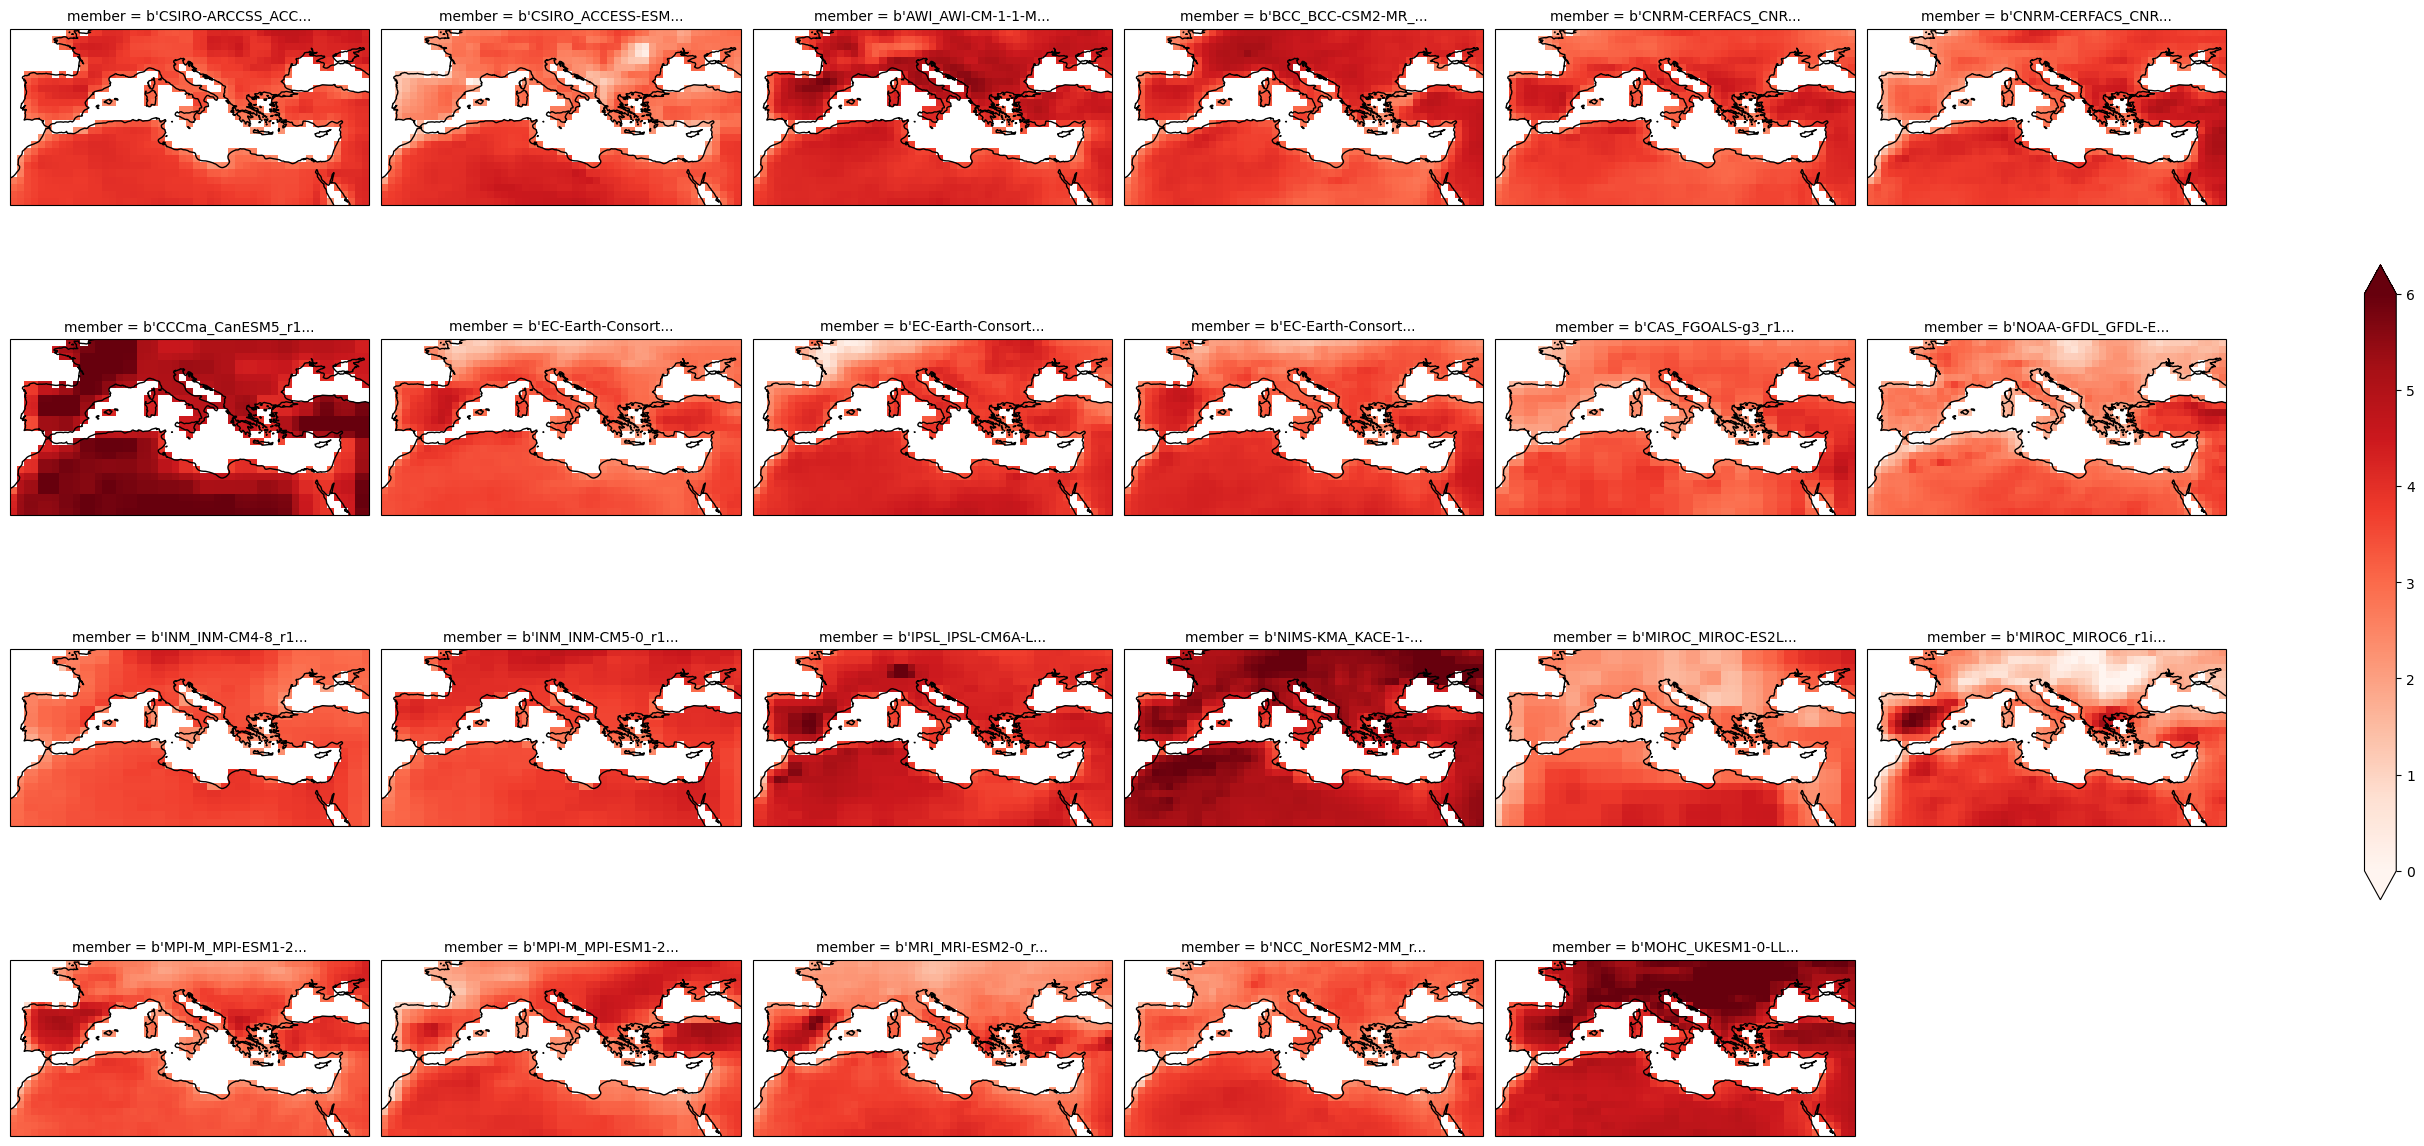

In [14]:
delta_land = delta * sftlf.where(sftlf==1)

plot = delta_land.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    vmin=0, vmax=6,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((-11,40,25,50), ccrs.PlateCarree())

plot.fig.savefig("txx-delta-land.svg")

### 4. Generate regionalized information

To get regionalized outcomes, we could consider any region within our study area. In this example, we use one of the IPCC-WGI Reference Regions available at [**IPCC-WGI/Atlas GitHub repository**](https://github.com/IPCC-WG1/Atlas/tree/main/warming-levels). 

In [15]:
regions_url = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/refs/heads/main/reference-regions/IPCC-WGI-reference-regions-v4.geojson"
regions_file = regions_url.split("/")[-1]

with open(regions_file, "w") as f:
    r = requests.get(regions_url)
    r.raise_for_status()
    f.write(r.text)

with open(regions_file, "r") as f:
    regions = json.load(f)

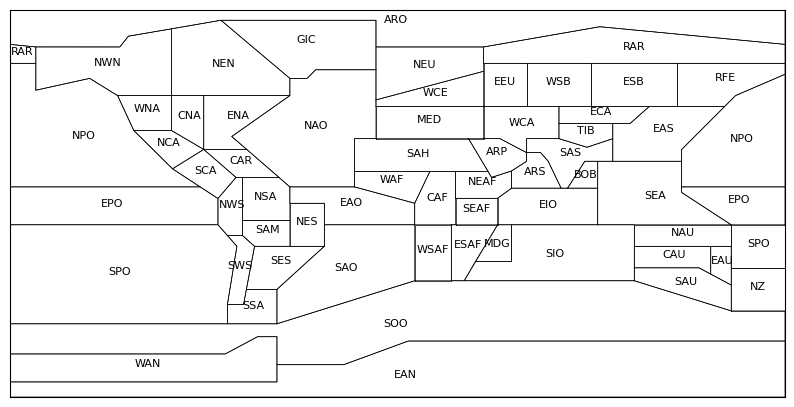

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(
    llcrnrlon=-180, urcrnrlon=180,
    llcrnrlat=-90, urcrnrlat=90,
    resolution="i", ax=ax)

def plot_polygon(coordinates, text, **kwargs):
    for polygon in coordinates:
        x, y = zip(*polygon)
        x, y = m(x, y)  # convert to map projection
        m.plot(x, y, marker=None, **kwargs)

        flat_coords = [point for ring in coordinates for point in ring]
        avg_lon = sum(point[0] for point in flat_coords) / len(flat_coords)
        avg_lat = sum(point[1] for point in flat_coords) / len(flat_coords)
        cx, cy = m(avg_lon, avg_lat)
        ax.text(cx, cy, text, fontsize=8, ha="center", color="black")

for feature in regions["features"]:
    geometry = feature["geometry"]
    geom_type = geometry["type"]
    label = feature["properties"]["Acronym"]

    if geom_type == "Polygon":
        plot_polygon(geometry["coordinates"], label, color="black", lw=.5)

    elif geom_type == "MultiPolygon":
        for polygon in geometry["coordinates"]:
            plot_polygon(polygon, label, color="black", lw=.5)

In [17]:
med = None
for feature in regions["features"]:
    if feature["properties"]["Acronym"] == "MED":
        med = feature.copy()
med["properties"]

{'id': '19',
 'Continent': 'EUROPE-AFRICA',
 'Type': 'Land-Ocean',
 'Name': 'Mediterranean',
 'Acronym': 'MED'}

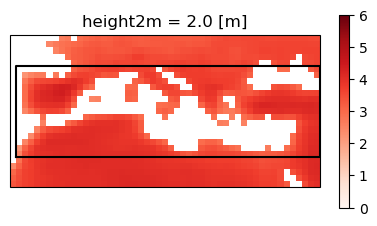

In [18]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

plot = ens_mean_land.plot(
    ax=ax,
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    vmin=0, vmax=6,
    transform=ccrs.PlateCarree())

for polygon in med["geometry"]["coordinates"]:
    x, y = zip(*polygon)
    x, y = m(x, y)  # convert to map projection
    ax.plot(x, y, marker=None, color="black")

In this example we are going to focus on the *Mediterranean* (MED). To calculate the intersection between the grid of the dataset and the *MED* region we will use the [Ray casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm).

In [19]:
def point_in_polygon(x, y, poly):
    n = len(poly)
    inside = False
    p1x, p1y = poly[0]
    for i in range(n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

Generate the mask.

In [20]:
lat, lon = ens_mean_land.coords['lat'], ens_mean_land.coords['lon']
mask = np.zeros((len(lat), len(lon)), dtype=bool)

for i, lat_val in enumerate(lat.values):
    for j, lon_val in enumerate(lon.values):
        mask[i, j] = point_in_polygon(lon_val, lat_val, med["geometry"]["coordinates"][0])

Plot applying the mask.

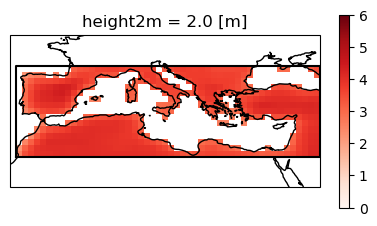

In [21]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0)))

plot = ens_mean_land.where(mask).plot(
    ax=ax,
    cmap="Reds",
    cbar_kwargs={"shrink": .5},
    vmin=0, vmax=6,
    transform=ccrs.PlateCarree())

for polygon in med["geometry"]["coordinates"]:
    x, y = zip(*polygon)
    ax.plot(x, y, marker=None, color="black")

ax.coastlines()

Next, we show an example of generating regional stripes, although other visualizations could also be created. First, we average the data yearly and next we calculate the historical climatology to serve as the reference baseline.

In [22]:
cmip6_ssp370_y = cmip6_ssp370["txx"].resample({"time": "Y"}).mean()
cmip6_hist_c = cmip6_hist["txx"].mean("time")
year_delta = cmip6_ssp370_y - cmip6_hist_c

# just for the plot to work correctly
year_delta["member"] = [x.decode("ascii") for x in year_delta["member"].values]

Perform the spatial aggregation and plots the stripes. 

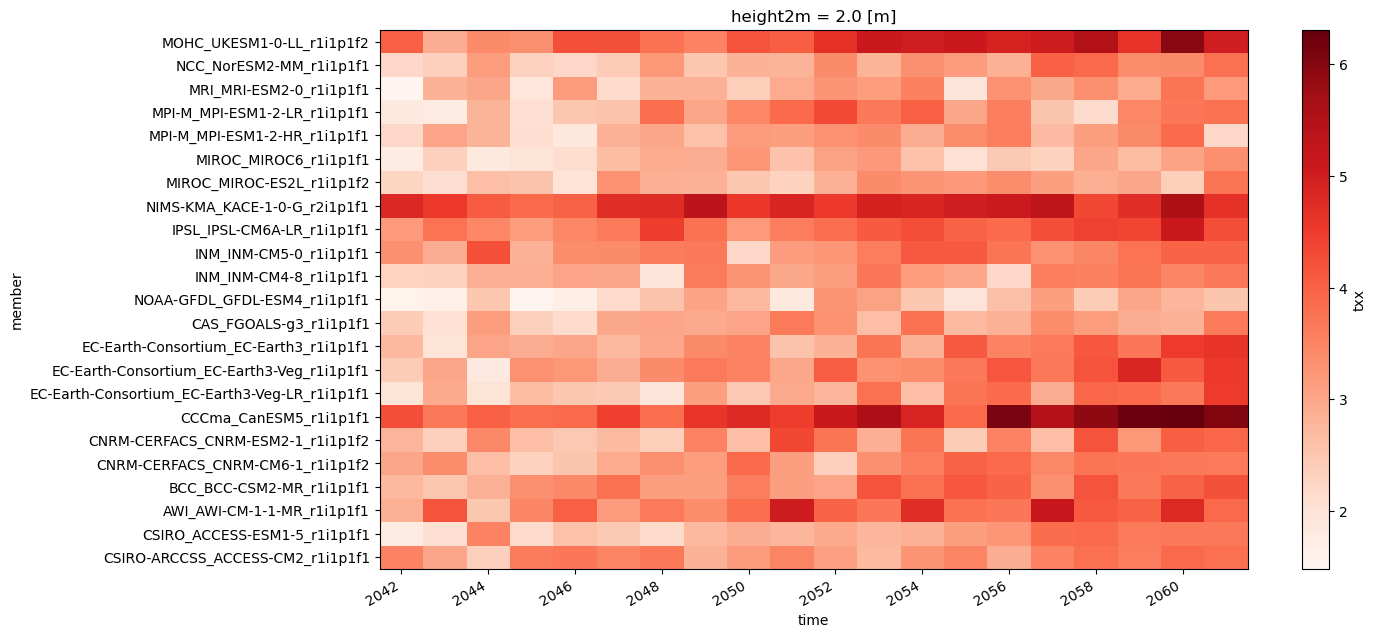

In [23]:
year_delta.mean(["lat", "lon"]).plot.imshow(
    figsize=(14,7),
    add_colorbar=True,
    cmap="Reds")

Next the stripes of the historical reference are plotted.

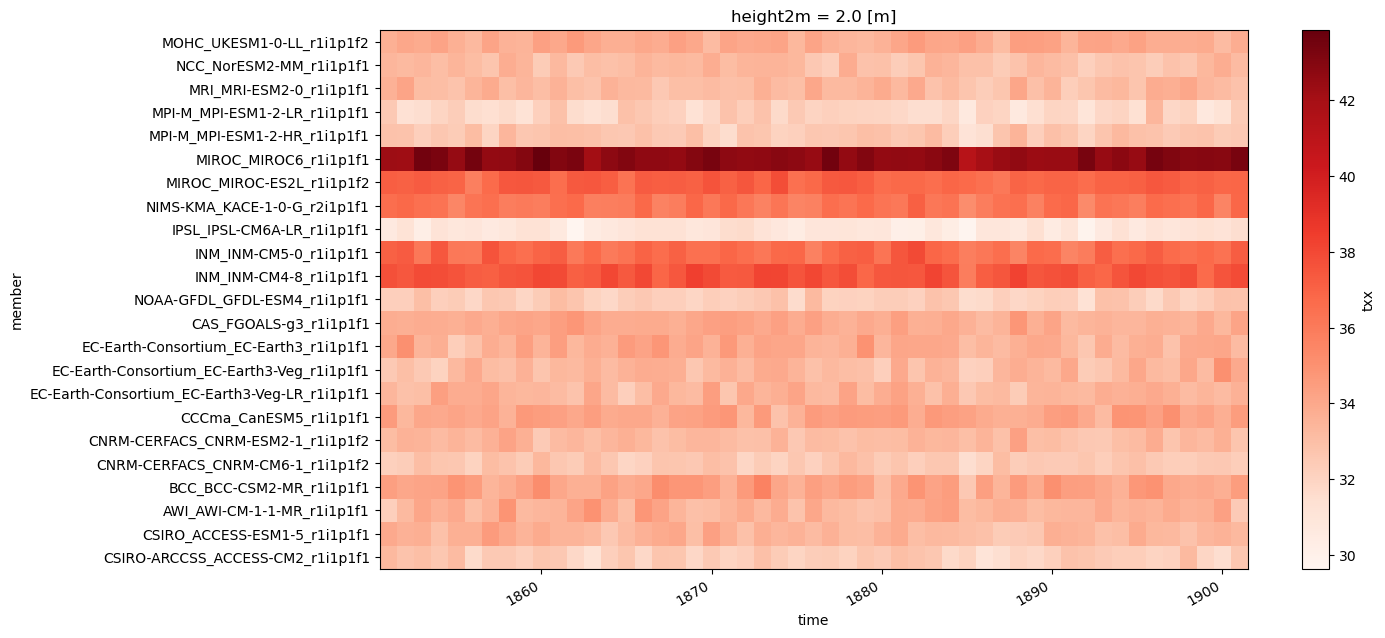

In [24]:
cmip6_hist_stripes = cmip6_hist.copy()
cmip6_hist_stripes["member"] = [x.decode("ascii") for x in cmip6_hist_stripes["member"].values]

cmip6_hist_stripes["txx"].resample({"time": "Y"}).mean().mean(["lat", "lon"]).plot.imshow(
    figsize=(14,7),
    add_colorbar=True,
    cmap="Reds")